## Introduction and plan



### 1. Dataset Selection

We have chosen the Fashion-MNIST dataset. It consists of 70,000 grayscale images (28x28 pixels) categorized into 10 classes of clothing and accessories. This dataset serves as a more challenging replacement for the original MNIST digits dataset, requiring the model to learn more complex textures and shapes.

### 2. Pretraining Model Selection

- Model: ConvNeXt (tiny) — chosen for transfer learning.
-
- Justification: ConvNeXt is a modern convolutional architecture that improves on many design choices while keeping the efficient convolutional inductive bias. The "tiny" variant is lightweight and fast, which is suitable for our dataset and compute budget; its pretrained ImageNet features transfer well to Fashion-MNIST. We use feature extraction (freeze base, train classifier) as a robust transfer strategy.

### 3. Transfer Learning Strategy

- Approach: We will use feature extraction by freezing the convolutional base of ConvNeXt (tiny).

- Justification: Freezing the convolutional base allows us to leverage the learned ImageNet features while only training the final classifier on our specific dataset. This reduces training time and computational resources while still achieving good performance.

- Modifications: We will replace the final classifier of ConvNeXt with a new linear layer tailored to the 10 classes of the Fashion-MNIST dataset.

- Training: We will train the new classification layer using the Fashion-MNIST training set while keeping the convolutional base frozen. After the initial training of the classification head, we may unfreeze the final blocks and continue training with a lower learning rate to refine the model for fashion-specific textures.

- Hyperparameters: We will use a learning rate of 0.001 for the classification head and 0.0001 for fine-tuning, with a batch size of 32 and training for 10 epochs initially.

- Optimization: We will use the Adam optimizer for its adaptive learning rate capabilities, which is beneficial for transfer learning scenarios.



### 4. Preprocessing & Augmentation Strategy

- Resize & RGB Conversion: Since the pretrained ConvNeXt models were trained on ImageNet (color images), we will resize the 28x28 images to 224x224 and convert grayscale to 3-channel RGB.

- Augmentation: We will use RandomHorizontalFlip and RandomRotation to increase model robustness and prevent overfitting.

- Normalization: We will normalize the pixel values using the standard ImageNet mean and standard deviation to align with the pretrained weights

### 5. Evaluation Metrics

We will monitor Cross-Entropy Loss and Accuracy. We will use TensorBoard to log these metrics for every run to ensure a fair comparison between the pretrained model and the CNN from scratch.

## Data exploration and preprocessing

We will implement the preprocessing and augmentation strategies outlined in our planning phase. This includes resizing, converting to RGB, applying augmentations, and normalizing the images.

Import necessary libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchvision

#### 1. Setup TensorBoard writer

In [3]:
writer = SummaryWriter('logs/fashion_mnist_experiments')

#### 2. Define Transforms

We resize to 224 for the pretrained model and convert to 3 channels 

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Grayscale(num_output_channels=3), # Pretrained models expect 3 channels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 3. Load Dataset

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms['train'])
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]

100%|██████████| 29.5k/29.5k [00:00<00:00, 1.10MB/s]

100%|██████████| 4.42M/4.42M [00:00<00:00, 9.38MB/s]

100%|██████████| 5.15k/5.15k [00:00<00:00, 9.72MB/s]



#### 4. Exploratory Data Analysis (EDA) - Visualizing the data

Get some random training images

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Show images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8025708].


GroundTruth:  Ankle boot Sneaker Coat Ankle boot


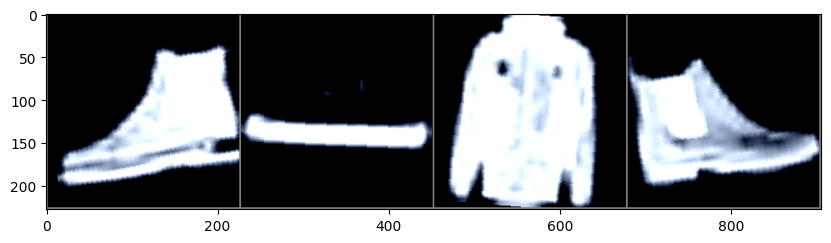

In [14]:
plt.figure(figsize=(10,5))
print('GroundTruth: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[:4]))

In [29]:
# === Environment, Splits, and Additional Imports ===
import os
import copy
import time
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import pandas as pd
from torch.utils.tensorboard import SummaryWriter

# Reproducibility
torch.manual_seed(42)

# Create train/validation split from the existing `train_dataset`
val_fraction = 0.1
val_size = int(val_fraction * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Replace train loader with subset and create val_loader
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {len(test_dataset)}")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

sample_inputs, sample_labels = next(iter(train_loader))
sample_inputs = sample_inputs.to(device)
with torch.no_grad():
    sample_outputs = model(sample_inputs[:4])
print('Output shape (batch 4):', sample_outputs.shape)

Train size: 54000, Val size: 6000, Test size: 10000
Using device: cuda
Output shape (batch 4): torch.Size([4, 10])


## Baseline model

#### Training utilities & logging

The notebook includes helper functions for training, evaluation, checkpointing, and plotting.

- **train_model**: trains the model, logs metrics to TensorBoard (when a writer is supplied), and keeps the best model by validation accuracy.
- **evaluate_model**: computes loss and accuracy on a dataloader.
- **save_checkpoint**: stores model and optimizer state along with training history under `saved_models/`.
- **plot_history**: convenience plotting for loss and accuracy curves.

All experiments below follow the same protocol: feature-extract ConvNeXt (freeze base), train the classifier head, log to `logs/`, and save the best checkpoints to `saved_models/`.

In [31]:
import os
import copy
from tqdm import tqdm
import torch
import torch.nn as nn

__all__ = [
    'load_pretrained_convnext',
    'save_checkpoint',
    'evaluate_model',
    'train_model',
    'plot_history'
]


def load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny'):
    """Minimal ConvNeXt tiny loader used in this notebook.

    - Supports only the 'tiny' variant (used everywhere in this notebook).
    - Uses the `weights=` enum API when pretrained=True for explicit reproducibility.
    - Freezes the base if requested and replaces the final classifier's last
      Linear layer with a new Linear(num_classes).
    """
    if variant != 'tiny':
        raise ValueError("Only the 'tiny' variant is supported in this notebook")

    # Import lazily to keep startup light
    from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

    weights = ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
    model = convnext_tiny(weights=weights)

    if freeze_base:
        for p in model.parameters():
            p.requires_grad = False

    # Replace last Linear in classifier (typical ConvNeXt structure)
    cls = model.classifier
    if isinstance(cls, nn.Sequential):
        # find last Linear module and replace it; fail loudly if it's not present
        for i in range(len(cls) - 1, -1, -1):
            if isinstance(cls[i], nn.Linear):
                in_features = cls[i].in_features
                cls[i] = nn.Linear(in_features, num_classes)
                model.classifier = cls
                break
        else:
            raise ValueError(
                "Could not find a `nn.Linear` module in the classifier `nn.Sequential`. "
                "Please inspect `model.classifier` and update `load_pretrained_convnext` accordingly."
            )
    elif isinstance(cls, nn.Linear):
        model.classifier = nn.Linear(cls.in_features, num_classes)
    else:
        raise ValueError(
            f"Unexpected classifier type {type(cls)}. Expected `nn.Sequential` containing a `nn.Linear` or a single `nn.Linear`. "
            "Inspect `model.classifier` and adapt the loader."
        )

    return model


def save_checkpoint(model, optimizer, epoch, history, save_path):
    """Save a checkpoint containing model and optimizer states and history."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, save_path)


def evaluate_model(model, dataloader, device):
    """Evaluate model on a dataloader and return loss and accuracy."""
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


def train_model(model, criterion, optimizer, train_loader, val_loader,
                num_epochs, device, writer=None, run_name='run'):
    """Train model and optionally log to a TensorBoard writer.

    Returns the best model (by validation accuracy) and a history dict.
    """
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, device)

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar(f'{run_name}/Loss/train', epoch_train_loss, epoch)
            writer.add_scalar(f'{run_name}/Loss/val', val_loss, epoch)
            writer.add_scalar(f'{run_name}/Accuracy/train', epoch_train_acc, epoch)
            writer.add_scalar(f'{run_name}/Accuracy/val', val_acc, epoch)

        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # deep copy the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history


def plot_history(history, label_prefix='Baseline'):
    """Return a matplotlib figure plotting loss and accuracy from history dict."""
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history['train_loss'], label=f'{label_prefix} - Train')
    axes[0].plot(history['val_loss'], label=f'{label_prefix} - Val')
    axes[0].set_title(f'{label_prefix} Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history['train_acc'], label=f'{label_prefix} - Train')
    axes[1].plot(history['val_acc'], label=f'{label_prefix} - Val')
    axes[1].set_title(f'{label_prefix} Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()
    return fig

In [32]:
print('\nSanity check: build ConvNeXt (tiny) and run a forward pass on one batch (using local loader)')
convnext_variant = 'tiny'
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant=convnext_variant)
model = model.to(device)
model.eval()
with torch.no_grad():
    sample_outputs = model(sample_inputs[:4])
print('Selected model: convnext (variant=', convnext_variant, ') Output shape (batch 4):', sample_outputs.shape)


Sanity check: build ConvNeXt (tiny) and run a forward pass on one batch (using local loader)
Selected model: convnext (variant= tiny ) Output shape (batch 4): torch.Size([4, 10])
Selected model: convnext (variant= tiny ) Output shape (batch 4): torch.Size([4, 10])


### Baseline — smoke test (1 epoch)

Quick smoke test to verify the training loop runs end-to-end.

Settings: feature extraction (freeze base), Adam optimizer, LR=0.001, batch size 32, 1 epoch. We log to `logs/baseline_convnext_smoke` and save a checkpoint to `saved_models/baseline_convnext_smoke/`.

In [25]:
num_epochs = 1
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
trainable_params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainable_params, lr=0.001)

baseline_writer = SummaryWriter('logs/baseline_convnext_smoke')

print('\nStarting 1-epoch baseline (feature-extract ConvNeXt tiny) smoke test')
model, baseline_smoke_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    writer=baseline_writer,
    run_name='baseline_convnext_smoke'
)

save_checkpoint(model, optimizer, num_epochs, baseline_smoke_history, 'saved_models/baseline_convnext_smoke/checkpoint.pth')
baseline_writer.close()

baseline_model = model
baseline_history = baseline_smoke_history
print('\n1-epoch baseline finished; history keys:', list(baseline_history.keys()))


Starting 1-epoch baseline (feature-extract ConvNeXt tiny) smoke test

Epoch 1/1


Training: 100%|██████████| 1688/1688 [03:40<00:00,  7.65it/s]



Starting 1-epoch baseline (feature-extract ConvNeXt tiny) smoke test

Epoch 1/1


Training: 100%|██████████| 1688/1688 [03:40<00:00,  7.65it/s]


Train Loss: 0.4235 Acc: 0.8560
Val   Loss: 0.3263 Acc: 0.8820

1-epoch baseline finished; history keys: ['train_loss', 'train_acc', 'val_loss', 'val_acc']

1-epoch baseline finished; history keys: ['train_loss', 'train_acc', 'val_loss', 'val_acc']


### Full Baseline — 10 epochs

Full baseline run using feature extraction to get reliable validation metrics.

Settings: Adam optimizer, LR=0.001, batch size 32, 10 epochs. Logs: `logs/baseline_convnext`. Checkpoint: `saved_models/baseline_convnext/`.

In [16]:
num_epochs = 10
model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
trainable_params = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
baseline_optimizer = optim.Adam(trainable_params, lr=0.001)

baseline_writer = SummaryWriter('logs/baseline_convnext')

print('\nStarting full baseline (feature-extract ConvNeXt tiny) 10-epoch run')
baseline_model, baseline_history = train_model(
    model=model,
    criterion=criterion,
    optimizer=baseline_optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    writer=baseline_writer,
    run_name='baseline_convnext'
)

save_checkpoint(baseline_model, baseline_optimizer, num_epochs, baseline_history, 'saved_models/baseline_convnext/checkpoint.pth')
baseline_writer.close()

print('\nBaseline training finished. Final Val Acc:', baseline_history['val_acc'][-1])


Starting full baseline (feature-extract ConvNeXt tiny) 10-epoch run

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:35<00:00,  7.82it/s]


Train Loss: 0.4208 Acc: 0.8561
Val   Loss: 0.3391 Acc: 0.8795

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:44<00:00,  7.51it/s]


Train Loss: 0.3176 Acc: 0.8857
Val   Loss: 0.3110 Acc: 0.8867

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:41<00:00,  7.61it/s]


Train Loss: 0.3010 Acc: 0.8920
Val   Loss: 0.2917 Acc: 0.8952

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:44<00:00,  7.51it/s]


Train Loss: 0.2867 Acc: 0.8975
Val   Loss: 0.2905 Acc: 0.8943

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:42<00:00,  7.57it/s]


Train Loss: 0.2803 Acc: 0.8980
Val   Loss: 0.2850 Acc: 0.8963

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:41<00:00,  7.62it/s]


Train Loss: 0.2740 Acc: 0.9003
Val   Loss: 0.2841 Acc: 0.8962

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:37<00:00,  7.76it/s]


Train Loss: 0.2721 Acc: 0.9007
Val   Loss: 0.2684 Acc: 0.9015

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:19<00:00,  8.45it/s]


Train Loss: 0.2698 Acc: 0.9016
Val   Loss: 0.2753 Acc: 0.9013

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:41<00:00,  7.62it/s]


Train Loss: 0.2659 Acc: 0.9032
Val   Loss: 0.2737 Acc: 0.8992

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:44<00:00,  7.53it/s]


Train Loss: 0.2631 Acc: 0.9061
Val   Loss: 0.2651 Acc: 0.9023

Baseline training finished. Final Val Acc: 0.9023333333333333


## Hyperparameter experiments

### Hyperparameter sweep — Learning Rate

We run a sweep over learning rates [0.0003, 0.01, 0.003]. Each run trains for 10 epochs, logs to `logs/lr_<lr>` and saves a checkpoint to `saved_models/tuned_convnext_lr_<lr>/`.We use these logs to compare validation accuracy and pick the best LR.

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [17]:
learning_rates = [0.0003, 0.01, 0.003]
num_epochs = 10
tuned_histories = {}

for lr in learning_rates:
    print('\n' + '='*60)
    print(f'TRAINING WITH LEARNING RATE: {lr}')
    print('='*60)

    model = load_pretrained_convnext(num_classes=10, freeze_base=True, pretrained=True, variant='tiny')
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=lr)
    writer = SummaryWriter(f'logs/lr_{lr}')

    trained_model, history = train_model(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        device=device,
        writer=writer,
        run_name=f'lr_{lr}'
    )

    save_checkpoint(trained_model, optimizer, num_epochs, history, f'saved_models/tuned_convnext_lr_{lr}/checkpoint.pth')

    tuned_histories[lr] = history
    writer.close()

    print(f"\nCompleted training with LR={lr} | Best Val Acc: {max(history['val_acc']):.4f}")

print('\nHyperparameter tuning completed.')


TRAINING WITH LEARNING RATE: 0.0003

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:50<00:00,  7.33it/s]


Train Loss: 0.5460 Acc: 0.8311
Val   Loss: 0.3835 Acc: 0.8640

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:47<00:00,  7.42it/s]


Train Loss: 0.3619 Acc: 0.8729
Val   Loss: 0.3489 Acc: 0.8760

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:31<00:00,  7.99it/s]


Train Loss: 0.3323 Acc: 0.8830
Val   Loss: 0.3218 Acc: 0.8807

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.92it/s]


Train Loss: 0.3164 Acc: 0.8871
Val   Loss: 0.3134 Acc: 0.8877

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.90it/s]


Train Loss: 0.3044 Acc: 0.8920
Val   Loss: 0.3013 Acc: 0.8907

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.92it/s]


Train Loss: 0.2969 Acc: 0.8941
Val   Loss: 0.2982 Acc: 0.8932

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.94it/s]


Train Loss: 0.2913 Acc: 0.8952
Val   Loss: 0.2948 Acc: 0.8922

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.94it/s]


Train Loss: 0.2856 Acc: 0.8983
Val   Loss: 0.2932 Acc: 0.8930

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.94it/s]


Train Loss: 0.2818 Acc: 0.8994
Val   Loss: 0.2845 Acc: 0.8942

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.93it/s]


Train Loss: 0.2787 Acc: 0.8998
Val   Loss: 0.2829 Acc: 0.8960

Completed training with LR=0.0003 | Best Val Acc: 0.8960

TRAINING WITH LEARNING RATE: 0.01

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.95it/s]


Train Loss: 0.5139 Acc: 0.8457
Val   Loss: 0.4975 Acc: 0.8665

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:31<00:00,  7.97it/s]


Train Loss: 0.4909 Acc: 0.8650
Val   Loss: 0.5137 Acc: 0.8763

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.96it/s]


Train Loss: 0.4868 Acc: 0.8715
Val   Loss: 0.5059 Acc: 0.8747

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:31<00:00,  7.97it/s]


Train Loss: 0.4857 Acc: 0.8744
Val   Loss: 0.5499 Acc: 0.8673

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.92it/s]


Train Loss: 0.4971 Acc: 0.8755
Val   Loss: 0.4982 Acc: 0.8770

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.90it/s]


Train Loss: 0.4857 Acc: 0.8769
Val   Loss: 0.6314 Acc: 0.8570

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.96it/s]


Train Loss: 0.4841 Acc: 0.8789
Val   Loss: 0.5544 Acc: 0.8702

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.95it/s]


Train Loss: 0.4823 Acc: 0.8801
Val   Loss: 0.4543 Acc: 0.8945

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.91it/s]


Train Loss: 0.5003 Acc: 0.8786
Val   Loss: 0.4683 Acc: 0.8872

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.93it/s]


Train Loss: 0.4969 Acc: 0.8805
Val   Loss: 0.4535 Acc: 0.8912

Completed training with LR=0.01 | Best Val Acc: 0.8945

TRAINING WITH LEARNING RATE: 0.003

Epoch 1/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.94it/s]


Train Loss: 0.3893 Acc: 0.8616
Val   Loss: 0.3156 Acc: 0.8858

Epoch 2/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.96it/s]


Train Loss: 0.3229 Acc: 0.8849
Val   Loss: 0.3886 Acc: 0.8648

Epoch 3/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.93it/s]


Train Loss: 0.3124 Acc: 0.8889
Val   Loss: 0.3259 Acc: 0.8875

Epoch 4/10


Training: 100%|██████████| 1688/1688 [03:33<00:00,  7.92it/s]


Train Loss: 0.3089 Acc: 0.8911
Val   Loss: 0.2914 Acc: 0.8965

Epoch 5/10


Training: 100%|██████████| 1688/1688 [03:32<00:00,  7.93it/s]


Train Loss: 0.3007 Acc: 0.8945
Val   Loss: 0.3316 Acc: 0.8917

Epoch 6/10


Training: 100%|██████████| 1688/1688 [03:31<00:00,  7.97it/s]


Train Loss: 0.2981 Acc: 0.8956
Val   Loss: 0.3171 Acc: 0.8918

Epoch 7/10


Training: 100%|██████████| 1688/1688 [03:31<00:00,  7.98it/s]


Train Loss: 0.2944 Acc: 0.8969
Val   Loss: 0.3478 Acc: 0.8832

Epoch 8/10


Training: 100%|██████████| 1688/1688 [03:23<00:00,  8.31it/s]


Train Loss: 0.2923 Acc: 0.8964
Val   Loss: 0.3132 Acc: 0.8958

Epoch 9/10


Training: 100%|██████████| 1688/1688 [03:19<00:00,  8.46it/s]


Train Loss: 0.2908 Acc: 0.8974
Val   Loss: 0.3348 Acc: 0.8852

Epoch 10/10


Training: 100%|██████████| 1688/1688 [03:18<00:00,  8.49it/s]


Train Loss: 0.2926 Acc: 0.8980
Val   Loss: 0.2826 Acc: 0.9027

Completed training with LR=0.003 | Best Val Acc: 0.9027

Hyperparameter tuning completed.



Plotting baseline history...


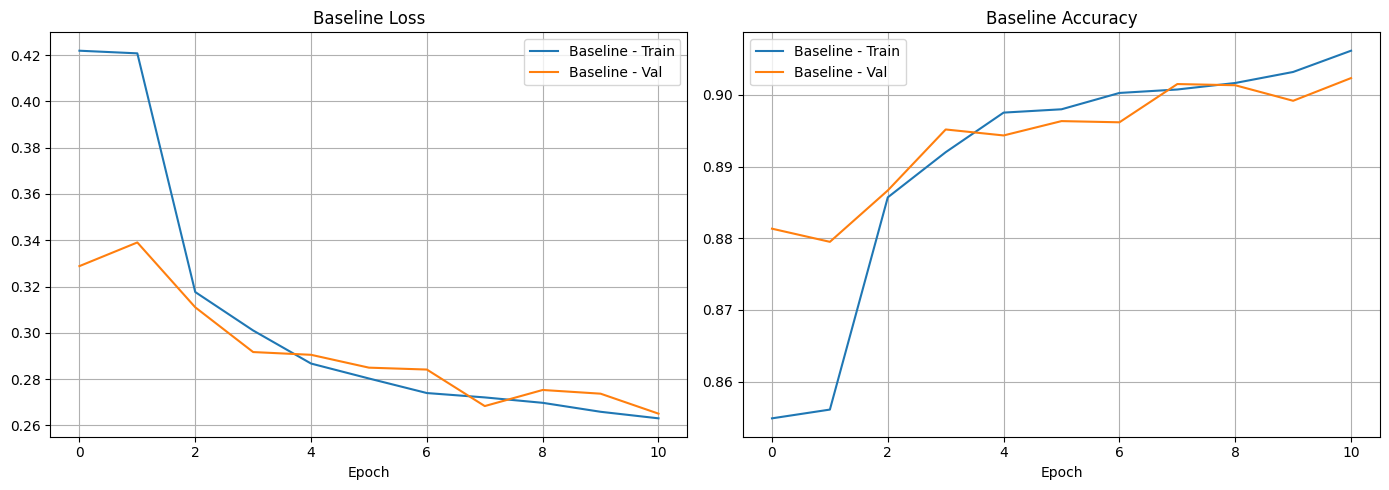


Plotting tuned models history...


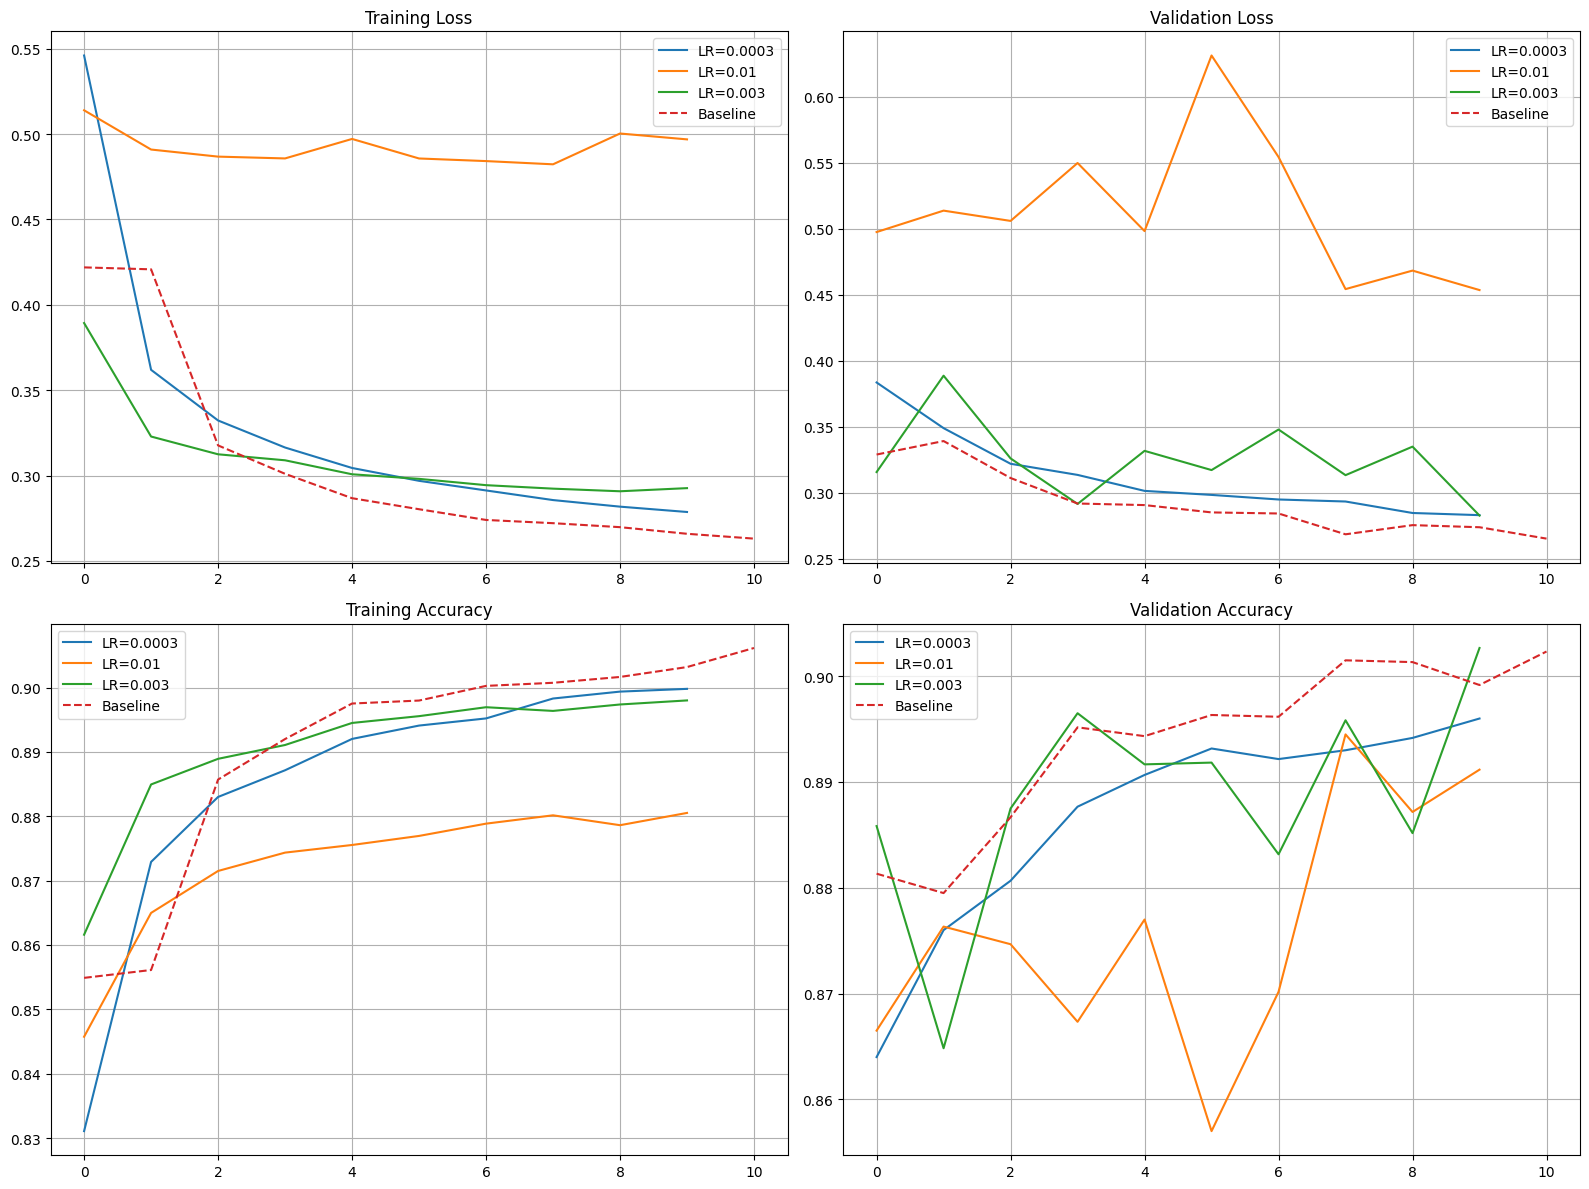

,Model,Learning Rate,Final Train Loss,Final Train Acc,Final Val Loss,Final Val Acc,Best Val Acc
0,Baseline,0.0010,0.263068,0.906148,0.265096,0.902333,0.902333
1,Tuned (LR=0.0003),0.0003,0.278668,0.899796,0.282892,0.896000,0.896000
2,Tuned (LR=0.01),0.0100,0.496864,0.880519,0.453525,0.891167,0.894500
3,Tuned (LR=0.003),0.0030,0.292631,0.898000,0.282579,0.902667,0.902667



BEST MODEL: Tuned (LR=0.003) with Best Val Acc = 0.9027


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if 'baseline_history' in globals():
    print('\nPlotting baseline history...')
    fig = plot_history(baseline_history, 'Baseline')
    fig.savefig('baseline_training_curves.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print('\nNo baseline history found. Run the baseline training cell to generate it.')

if 'tuned_histories' in globals() and len(tuned_histories) > 0:
    print('\nPlotting tuned models history...')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for lr, h in tuned_histories.items():
        axes[0].plot(h['train_loss'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[0].plot(baseline_history['train_loss'], label='Baseline', linestyle='--')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)

    for lr, h in tuned_histories.items():
        axes[1].plot(h['val_loss'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[1].plot(baseline_history['val_loss'], label='Baseline', linestyle='--')
    axes[1].set_title('Validation Loss')
    axes[1].legend()
    axes[1].grid(True)

    for lr, h in tuned_histories.items():
        axes[2].plot(h['train_acc'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[2].plot(baseline_history['train_acc'], label='Baseline', linestyle='--')
    axes[2].set_title('Training Accuracy')
    axes[2].legend()
    axes[2].grid(True)

    for lr, h in tuned_histories.items():
        axes[3].plot(h['val_acc'], label=f'LR={lr}')
    if 'baseline_history' in globals():
        axes[3].plot(baseline_history['val_acc'], label='Baseline', linestyle='--')
    axes[3].set_title('Validation Accuracy')
    axes[3].legend()
    axes[3].grid(True)

    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png', dpi=200, bbox_inches='tight')
    plt.show()
else:
    print('\nNo tuned histories found. Run the hyperparameter tuning cell to generate them.')

# Summary table
if 'baseline_history' in globals() or ('tuned_histories' in globals() and len(tuned_histories)>0):
    results_data = []
    if 'baseline_history' in globals():
        results_data.append({
            'Model': 'Baseline',
            'Learning Rate': 0.001,
            'Final Train Loss': baseline_history['train_loss'][-1],
            'Final Train Acc': baseline_history['train_acc'][-1],
            'Final Val Loss': baseline_history['val_loss'][-1],
            'Final Val Acc': baseline_history['val_acc'][-1],
            'Best Val Acc': max(baseline_history['val_acc'])
        })
    if 'tuned_histories' in globals():
        for lr, h in tuned_histories.items():
            results_data.append({
                'Model': f'Tuned (LR={lr})',
                'Learning Rate': lr,
                'Final Train Loss': h['train_loss'][-1],
                'Final Train Acc': h['train_acc'][-1],
                'Final Val Loss': h['val_loss'][-1],
                'Final Val Acc': h['val_acc'][-1],
                'Best Val Acc': max(h['val_acc'])
            })
    results_df = pd.DataFrame(results_data)
    display(results_df)
    if not results_df.empty:
        best_idx = results_df['Best Val Acc'].idxmax()
        best_model = results_df.iloc[best_idx]
        print(f"\nBEST MODEL: {best_model['Model']} with Best Val Acc = {best_model['Best Val Acc']:.4f}")
else:
    print('\nNo results to summarize yet.')